In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
from scipy.optimize import curve_fit

# Study Summary
A study seeks to quantify the effectivity of a drug in a clinical population with systemic hypertension (SH). The team enrolled 250 patients with diagnosis of SH and no other known comorbidities. For each individual, the systolic blood pressure was measured after a minimum of 12 hours of fasting. Then, a random safe dose of the tested drug within acceptable thresholds was administered daily during a period of 30 days, after which the systolic blood pressure was measured again.

The principal investigator of this project is interested in quantifying if the systolic blood pressure can be predicted after 30 days of treatment based on the measured values before the treatment, the administered drug dose and basic patient information such as age and/or sex.

In [3]:
# Import data
WORK_DIR = os.getcwd()
filename = 'BloodPressureData.xlsx'
data = pd.read_excel(f'{WORK_DIR}/{filename}')
data.head(5)

,Age (years),"Sex (0:female, 1:male)",Initial systolic pressure (mm Hg),Drug dose (mg),Systolic pressure after treatment (mm Hg)
0,86,0,171.221889,7.144833,153.874218
1,79,0,166.426064,7.984246,143.468111
2,90,1,163.676760,7.271092,148.559803
3,85,1,146.621486,7.770628,124.180775
4,81,1,142.752645,7.233099,123.560301


# Regression Model
Build and evaluate a regression model that can predict the systolic blood pressure after 30 days of treatment.

In [4]:
# Choose features and target and represent as numpy matrices
X = data.loc[:, data.columns != 'Systolic pressure after treatment (mm Hg)'].to_numpy()
y = data.loc[:, 'Systolic pressure after treatment (mm Hg)'].to_numpy()

In [5]:
# State variables in terms of x1, x2, x3, x4 - want to pull directly from data set
model_varnames = [f'x{i+1}' for i in range(0, len(data.columns)-1)]
varnames = data.loc[:, data.columns != 'Systolic pressure after treatment (mm Hg)'].columns
varname_dict = dict(zip(model_varnames, varnames))
for key, value in varname_dict.items():
    print(f'{key}: {value}')

x1: Age (years)
x2: Sex (0:female, 1:male)
x3: Initial systolic pressure (mm Hg)
x4: Drug dose (mg)


## Mathematical Equation Predicting the Systolic BP after 30 Days of Treatment

$$\hat{y} = \theta_0 + \theta_{1}x_1 + \theta_{2}x_2 + \theta_{3}x_3 + \theta_{4}x_4$$

$$\hat{y} = -7.40 + 0.06x_1 + 2.79x_2 + 1.02x_3 + -3.07x_4$$

Where...
- $\hat{y}$ is the target outcome, systolic pressure after treatment (mm Hg)
- $x_1$, $x_2$, $x_3$, and $x_4$ are the features
- $\theta_1$, $\theta_2$, $\theta_3$, and $\theta_4$ are the coefficients associated with each feature
- $\theta_0$ is the intercept, which is uninterpretable in this case

In [6]:
# Fit model and display results
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1489.
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.48e-170
Time:                        23:38:30   Log-Likelihood:                -651.85
No. Observations:                 250   AIC:                             1314.
Df Residuals:                     245   BIC:                             1331.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.4072      3.216     -2.303      0.0

## Performance Evaluation of the Predictive Model in the Training Dataset

In [7]:
# Print performance metrics
print(f'MAE: {round(sum(abs(model.resid)) / model.nobs, 2)}')
print(f'MSE: {round(sum(model.resid * model.resid) / model.nobs, 2)}')
#print(f'MSE: {round(model.mse_total, 2)}')
print(f'R-squared: {round(model.rsquared, 2)}')
print(f'Adjusted R-squared: {round(model.rsquared_adj, 2)}')

MAE: 2.55
MSE: 10.77
R-squared: 0.96
Adjusted R-squared: 0.96


- **Mean absolute error** does not penalize large prediction errors. An MAE of 2.55 is achieved by this model, compared to a perfect score of 0.
- **Mean squared error (MSE)** penalizes large prediction errors. An MSE of 10.77 is achieved by this model, compared to a perfect score of 0. The discrepancy that exists between MAE and MSE for this model might suggest the presence of some outlier residuals - although the discrepancy isn't large.
- **R-squared & Adjusted R-squared** are each 0.960. Considering perfect scores of 1 for these metrics, $R^2$ of 0.96 suggests good model performance.
  
*The next section asseses the relationship between residuals and features to check if model assumptions are met*

## Output File with Predicted Values in the Provided Data Set

In [8]:
# Predict systolic blood pressure after treatment using linear regression model
predictions = model.predict(X)
data['Predicted systolic pressure after treatment (mm Hg)'] = predictions

# Output to excel (BloodPressureData.predictions.xlsx)
data.to_excel(f'{WORK_DIR}/{filename.split(".")[0]}.predictions.xlsx')

# Model Diagnostics & Discussion

In [9]:
# Function to plot scatterplot; boolean flag used to display variable distributions (or not)
def res_scatter(df, x_col, y_col, joint_plot: bool):
    plt.figure()
    if joint_plot:
        plot = sns.jointplot(data=data, x=x_col, y=y_col, color="k", alpha=0.8, edgecolor="white", s=60)
        plot.ax_joint.axhline(y=0, lw=2)
    else:
        plot = sns.scatterplot(data=data, x=x_col, y=y_col, color="k", alpha=0.6, edgecolor="none", s=60)
        plot.axhline(y=0, lw=2)
    plt.show()
    
# Extract residuals
data['residuals'] = model.resid

## Residuals vs Predicted Outcome
The residual distribution is not evenly/normally distributed around zero. The skew exists due to outlier residual values above the y axis - these are observations in which the model underpredicted the true value.

<Figure size 432x288 with 0 Axes>

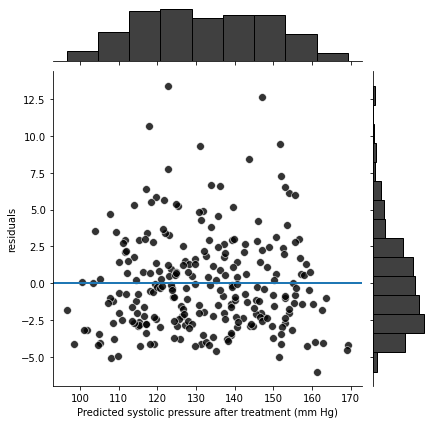

In [10]:
res_scatter(df=data, 
            x_col='Predicted systolic pressure after treatment (mm Hg)', y_col='residuals', 
            joint_plot=True)

## Individual Quantitative Effect of Variables on the Outcome

### Age

Age is associated with a $\theta$ value of 0.05 and a $p$-value of 0.018, suggesting a significant association between age and the outcome predicted. Theoretically, a $\theta$ value of 0.05 indicates that for every 1 year increase in age, systolic blood pressure increases by 0.05 units (mm Hg). However, the residual plot below shows a clear parabolic relationship between prediction error and age. This pattern tells us that a non-linear relationship likely exists between age and the outcome. We ought to update the linear regression model to account for this.

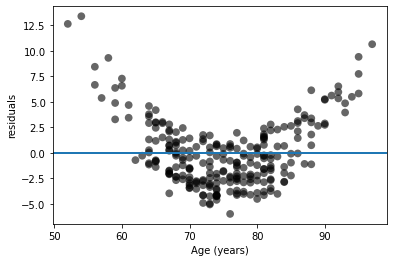

In [11]:
res_scatter(df=data, x_col='Age (years)', y_col='residuals', joint_plot=False)

### Sex
Age is associated with a $\theta$ value of 2.78 and a $p$-value of <0.001, suggesting a significant association between sex and the outcome predicted. A $\theta$ value of 2.78 indicates that males, on average, are associated with a 2.78 unit increase in systolic blood pressure when compared to females.

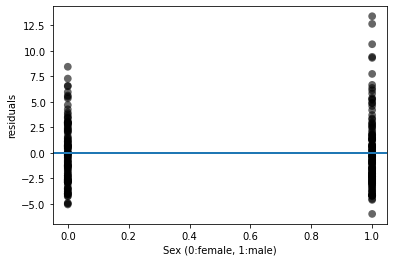

In [12]:
res_scatter(df=data, x_col='Sex (0:female, 1:male)', y_col='residuals', joint_plot=False)

### Initial Systolic Blood Pressure
Age is associated with a $\theta$ value of 1.02 and a $p$-value of <0.001, suggesting a significant association between initial systolic blood pressure and the outcome predicted. A $\theta$ value of 1.02 indicates that for every 1 unit increase in initial systolic blood pressure (mm Hg), systolic blood pressure increases by 1.02 units (mm Hg). The residual plot below indicates that a linear relationship is indeed observed between the variable and the outcome.

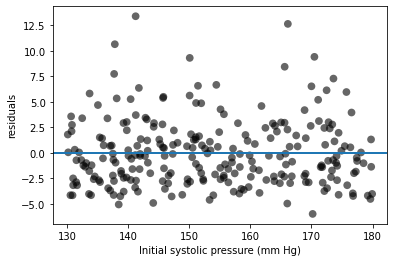

In [13]:
res_scatter(df=data, x_col='Initial systolic pressure (mm Hg)', y_col='residuals', joint_plot=False)

### Drug Dose
Drug dose is associated with a $\theta$ value of -3.07 and a $p$-value of <0.001, suggesting a significant association between initial systolic blood pressure and the outcome predicted. A $\theta$ value of -3.07 indicates that for every 1 unit increase in drug dose (mg), systolic blood pressure decreases by 3.07 units (mm Hg). The residual plot below indicates that a linear relationship is indeed observed between the variable and the outcome.

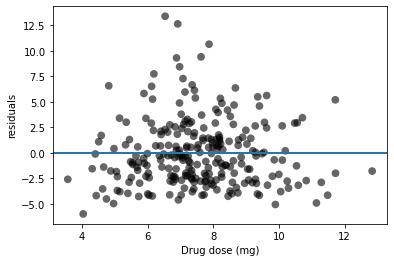

In [14]:
res_scatter(df=data, x_col='Drug dose (mg)', y_col='residuals', joint_plot=False)

# Non-Linear Regression Model
To be continued...